# Library Importation

In [92]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [101]:
models_dir = 'models'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# Data Importation

In [93]:
raw_bmi = pd.read_csv('bmi.csv')
raw_bmi

,Gender,Height,Weight,Index
0,Male,174,96,4
1,Male,189,87,2
2,Female,185,110,4
3,Female,195,104,3
4,Male,149,61,3
...,...,...,...,...
495,Female,150,153,5
496,Female,184,121,4
497,Female,141,136,5
498,Male,150,95,5


# Visualization

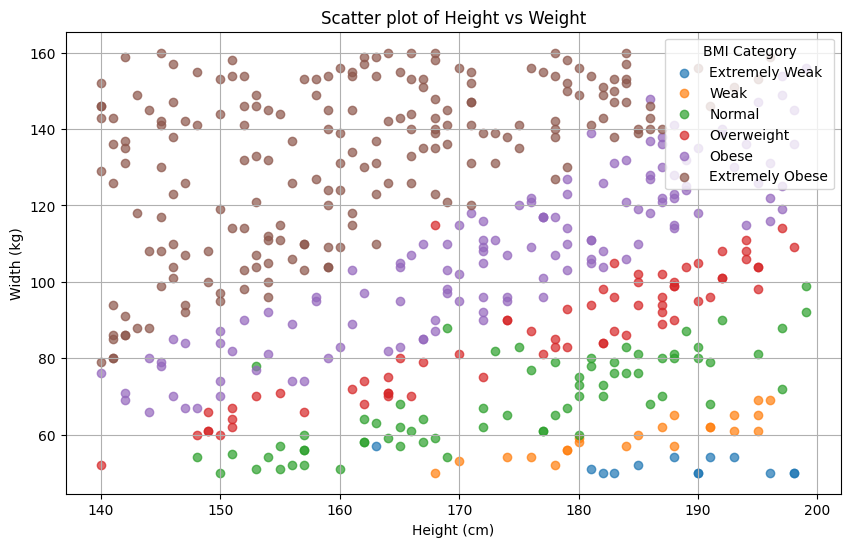

In [96]:
index_labels = {
    0: 'Extremely Weak',
    1: 'Weak',
    2: 'Normal',
    3: 'Overweight',
    4: 'Obese',
    5: 'Extremely Obese'
}

plt.figure(figsize=(10, 6))
for category in sorted(raw_bmi['Index'].unique()):
    subset = raw_bmi[raw_bmi['Index'] == category]
    plt.scatter(subset['Height'], subset['Weight'], label=index_labels[category], alpha=0.7)

plt.title('Scatter plot of Height vs Weight')
plt.xlabel('Height (cm)')
plt.ylabel('Width (kg)')
plt.legend(title='BMI Category')
plt.grid(True)
plt.show()

# Preprocessing

Turning the gender column into a numerical value


In [97]:
value_mapping = {'Male': 0, 'Female': 1}
raw_bmi['Gender'] = raw_bmi['Gender'].replace(value_mapping)
raw_bmi

/tmp/ipykernel_14654/2913014925.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  raw_bmi['Gender'] = raw_bmi['Gender'].replace(value_mapping)


,Gender,Height,Weight,Index
0,0,174,96,4
1,0,189,87,2
2,1,185,110,4
3,1,195,104,3
4,0,149,61,3
...,...,...,...,...
495,1,150,153,5
496,1,184,121,4
497,1,141,136,5
498,0,150,95,5


Scaling the values between -1 and 1

In [98]:
column_to_exclude = 'Index'
columns_to_scale = [col for col in raw_bmi.columns if col != column_to_exclude]

scaler = StandardScaler()
scaler.fit(raw_bmi[columns_to_scale])
raw_bmi[columns_to_scale] = scaler.transform(raw_bmi[columns_to_scale])
raw_bmi

,Gender,Height,Weight,Index
0,-1.020204,0.247939,-0.309117,4
1,-1.020204,1.164872,-0.587322,2
2,0.980196,0.920357,0.123647,4
3,0.980196,1.531645,-0.061823,3
4,-1.020204,-1.280283,-1.391027,3
...,...,...,...,...
495,0.980196,-1.219155,1.452850,5
496,0.980196,0.859228,0.463676,4
497,0.980196,-1.769315,0.927351,5
498,-1.020204,-1.219155,-0.340029,5


Saving the scaler to the models directory

In [99]:
filename = os.path.join(models_dir, 'scaler.sav')
joblib.dump(scaler, filename)

['models/scaler.sav']

Splitting the data into train and test subsets

In [100]:
X = raw_bmi.drop('Index', axis = 1)
y = raw_bmi['Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Support Vector Machines (SVM)

In [75]:
param_grid = [
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
    {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'coef0': [0.0, 1.0], 'degree': [2, 3, 4], 'kernel': ['poly']},
 ]

In [76]:
clf = svm.SVC()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [0.1, 1, 10, 100, 1000], 'coef0': [0.0, 1.0],
                          'degree': [2, 3, 4], 'gamma': [0.001, 0.0001],
                          'kernel': ['poly']}])

In [77]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_params

{'C': 1000, 'kernel': 'linear'}

In [78]:
y_pred = best_estimator.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         4
           2       0.95      1.00      0.97        18
           3       0.88      0.88      0.88         8
           4       0.96      0.90      0.93        30
           5       0.95      0.97      0.96        39

    accuracy                           0.95       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.95      0.95      0.95       100



In [79]:
filename = os.path.join(models_dir, 'svm_model.sav')
joblib.dump(best_estimator, filename)

['models/svm_model.sav']

# K-Nearest Neighbors (KNN)

In [49]:
param_grid = {
    'n_neighbors': np.arange(1, 25),
}

In [50]:
neigh = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=neigh, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [51]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_params

{'n_neighbors': 1}

In [52]:
y_pred = best_estimator.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.88
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         4
           2       0.88      0.83      0.86        18
           3       0.88      0.88      0.88         8
           4       0.92      0.80      0.86        30
           5       0.88      0.95      0.91        39

    accuracy                           0.88       100
   macro avg       0.87      0.91      0.88       100
weighted avg       0.89      0.88      0.88       100



In [102]:
filename = os.path.join(models_dir, 'knn_model.sav')
joblib.dump(best_estimator, filename)

['models/knn_model.sav']

# Random Forests

In [103]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

In [104]:
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8], 'max_features': ['sqrt'],
                         'n_estimators': [100, 200, 300]})

In [105]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_params

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [62]:
y_pred = best_estimator.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.86
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         4
           2       0.94      0.83      0.88        18
           3       0.64      0.88      0.74         8
           4       0.92      0.73      0.81        30
           5       0.88      0.95      0.91        39

    accuracy                           0.86       100
   macro avg       0.84      0.90      0.86       100
weighted avg       0.87      0.86      0.86       100



In [106]:
filename = os.path.join(models_dir, 'rf_model.sav')
joblib.dump(best_estimator, filename)

['models/rf_model.sav']

# XGBoost

In [69]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.7, 1],
    'subsample': [0.7, 1]
}

In [70]:
bst = XGBClassifier(objective='multi:softprob', random_state=42)
grid_search = GridSearchCV(estimator=bst, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.7, 1]})

In [71]:
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
best_params

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'subsample': 0.7}

In [72]:
y_pred = best_estimator.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.88
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.67      1.00      0.80         4
           2       0.89      0.89      0.89        18
           3       0.86      0.75      0.80         8
           4       0.92      0.80      0.86        30
           5       0.88      0.95      0.91        39

    accuracy                           0.88       100
   macro avg       0.87      0.90      0.88       100
weighted avg       0.89      0.88      0.88       100



In [107]:
filename = os.path.join(models_dir, 'xgb_model.sav')
joblib.dump(best_estimator, filename)

['models/xgb_model.sav']